# Импорты

In [3]:
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.4 MB/s eta 0:00:00


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import optuna
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder, TargetEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Perceptron, Ridge
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from matplotlib import gridspec
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, root_mean_squared_error
from sklearn.compose import ColumnTransformer
from mlxtend.plotting import plot_decision_regions
import warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
import lightgbm as lgb
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor, StackingRegressor
simplefilter("ignore", category=ConvergenceWarning)

warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Mounted at /content/drive


# Скачаем и посмотрим на данные

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/playground-series-s3e9/train.csv")
result_test = pd.read_csv("/content/drive/MyDrive/playground-series-s3e9/test.csv")

In [ ]:
df.head(7)

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19
5,5,350.0,0.0,0.0,203.0,0.0,1055.0,775.0,7,37.43
6,6,135.7,203.5,0.0,185.7,0.0,1076.2,759.3,28,35.10


In [ ]:
df.columns

Index(['id', 'CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays',
       'Strength'],
      dtype='object')

Описание полей:

- **id**: Идентификатор
- **CementComponent**: Количество добавленного цемента
- **BlastFurnaceSlag**: Количество добавленного доменного шлака
- **FlyAshComponent**: Количество добавленной летучей золы
- **WaterComponent**: Количество добавленной воды
- **SuperplasticizerComponent**: Количество добавленного суперпластификатора
- **CoarseAggregateComponent**: Количество добавленного крупного заполнителя
- **FineAggregateComponent**: Количество добавленного мелкого заполнителя
- **AgeInDays**: Сколько дней было оставлено на высыхание
- **Strength**: Какая была конечная прочность бетона (целевая)

In [ ]:
set(df["AgeInDays"].unique())

{1, 3, 7, 14, 28, 49, 56, 90, 91, 100, 120, 180, 270, 360, 365}

In [ ]:
set(result_test["AgeInDays"].unique())

{1, 3, 7, 11, 14, 28, 56, 90, 91, 100, 120, 180, 270, 360, 365}

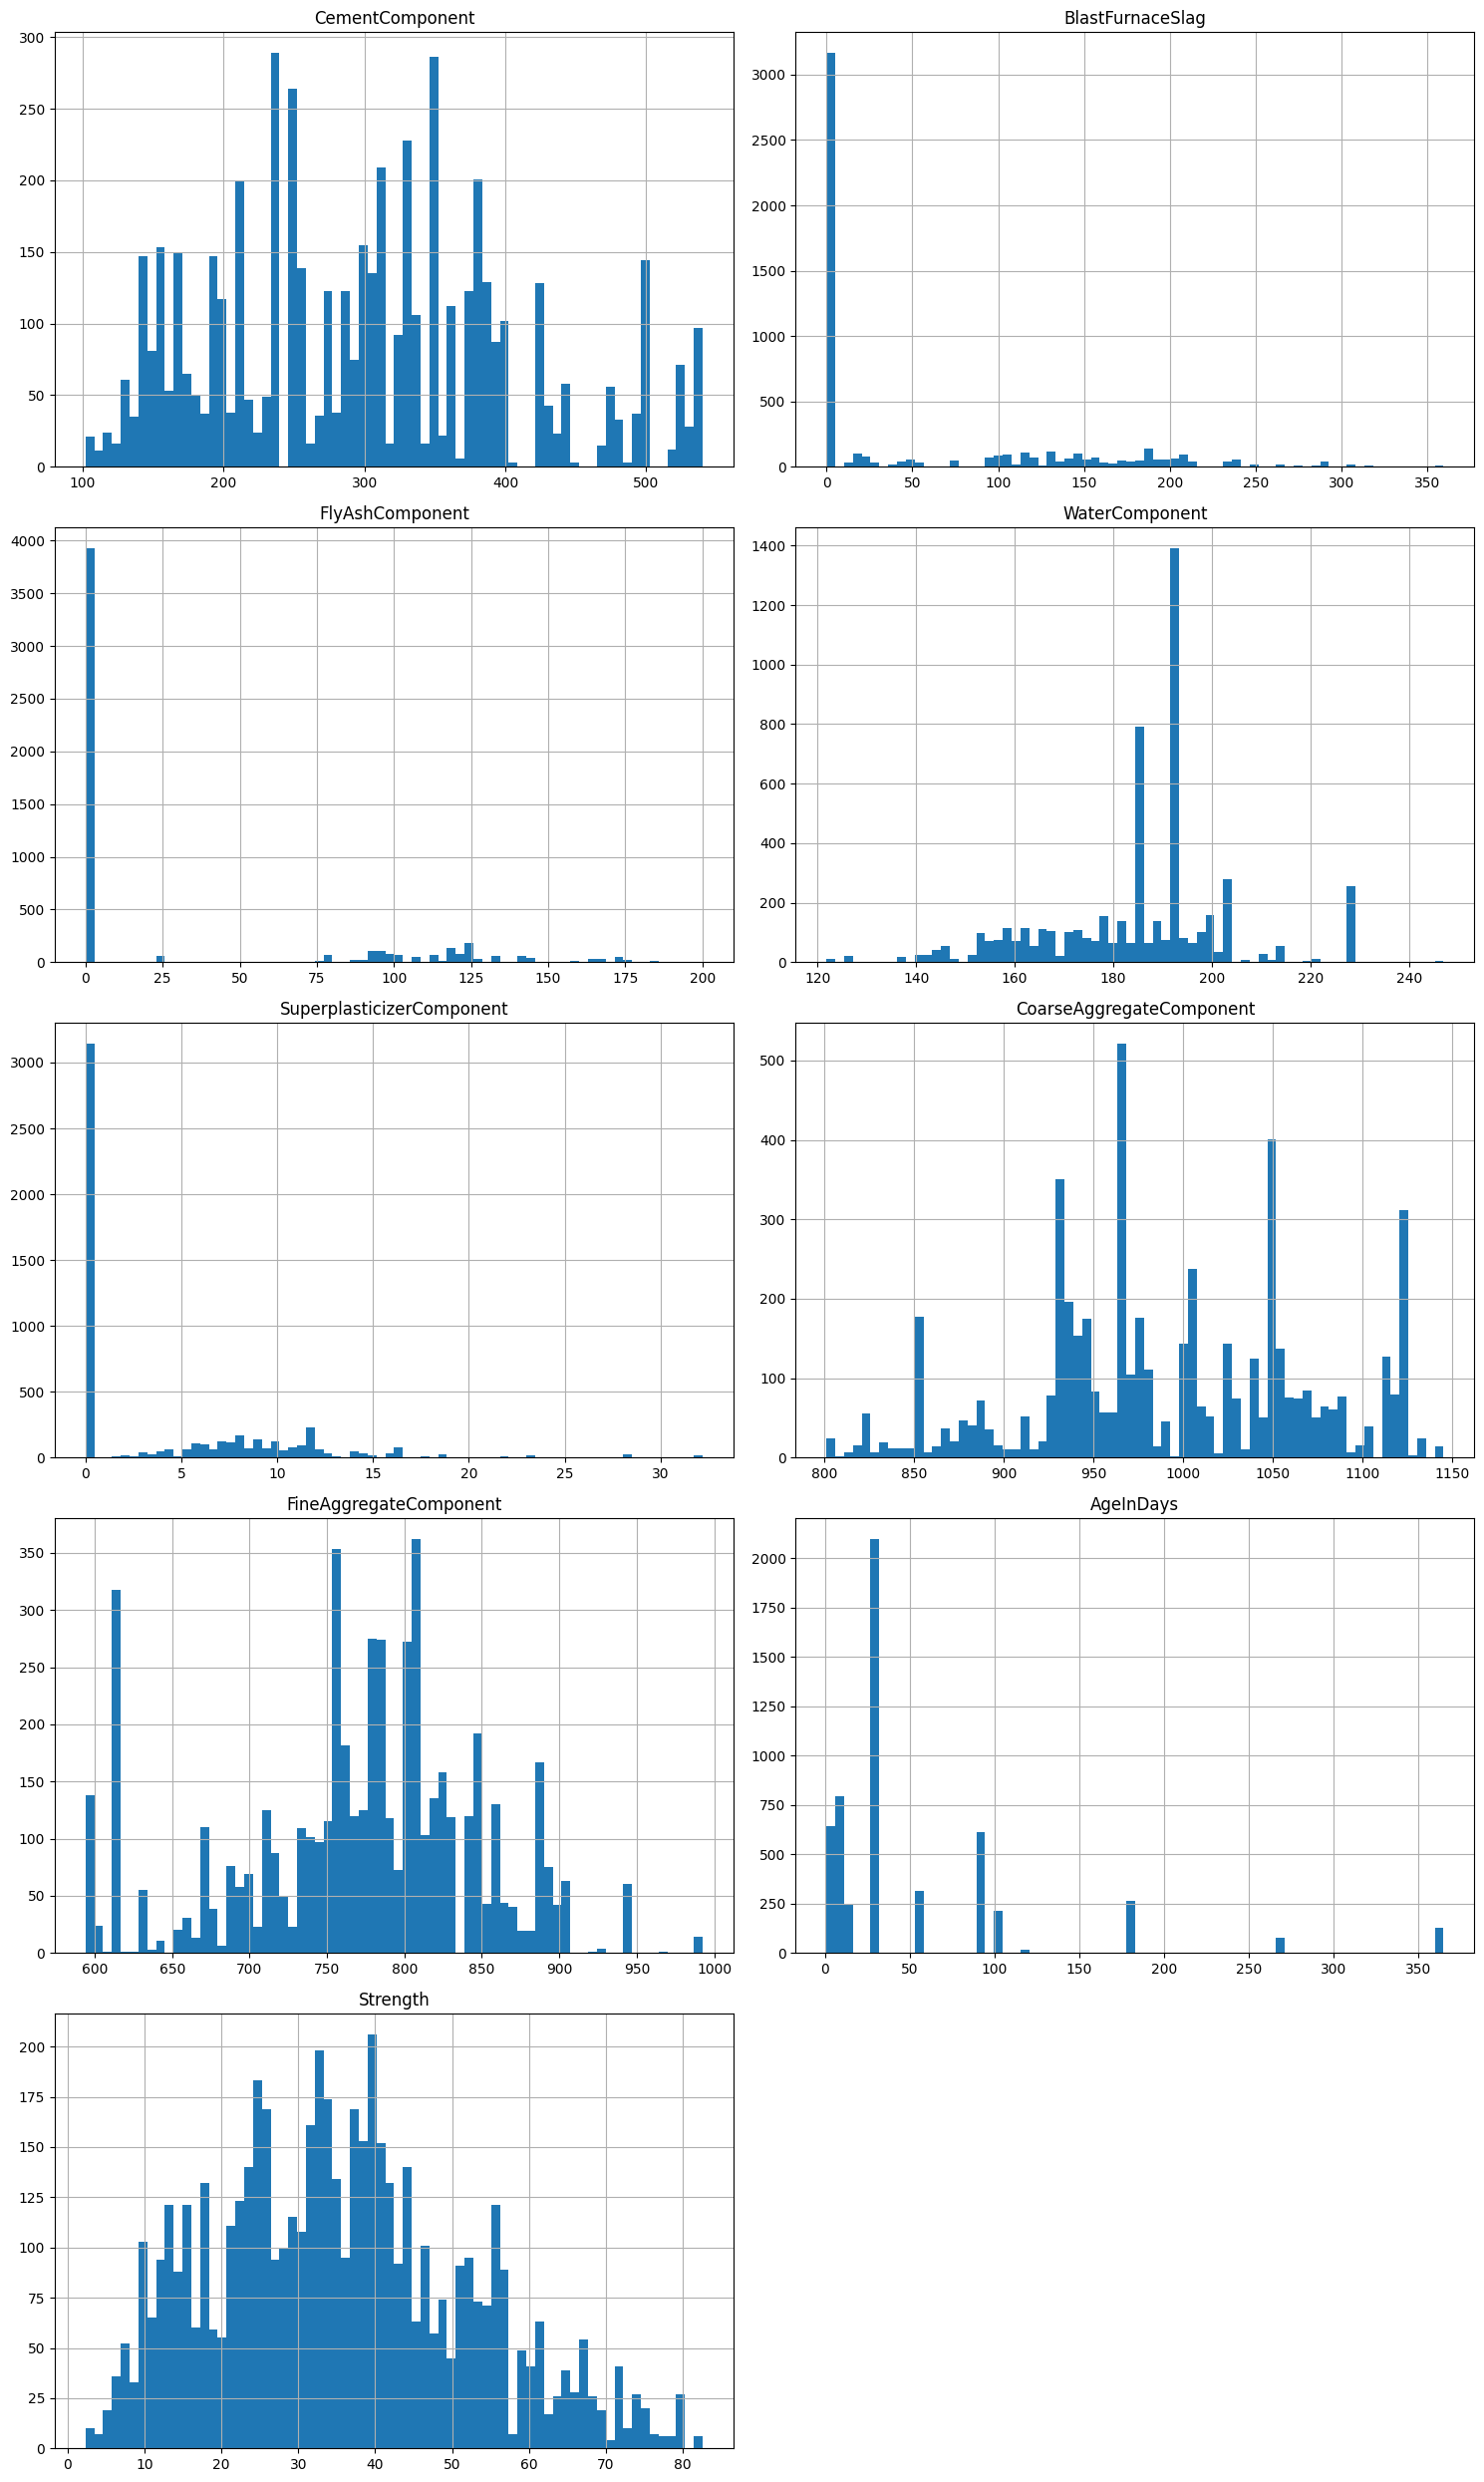

In [ ]:
feature_columns = df.columns[1:]

# Установите количество строк и столбцов
nrows = len(feature_columns) // 2 + len(feature_columns) % 2  # две гистограммы в строке
ncols = 2

# Создайте сублист с количеством строк и столбцов
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Разворачиваем массив axes, чтобы работа была проще, когда количество графиков не кратно количеству колонок
axes = axes.ravel()

# Построение каждой гистограммы отдельно
for i, column in enumerate(feature_columns):
    df[column].hist(ax=axes[i], bins=70)
    axes[i].set_title(column)

# Удалите оставшиеся пустые оси, если есть
for i in range(len(feature_columns), nrows * ncols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

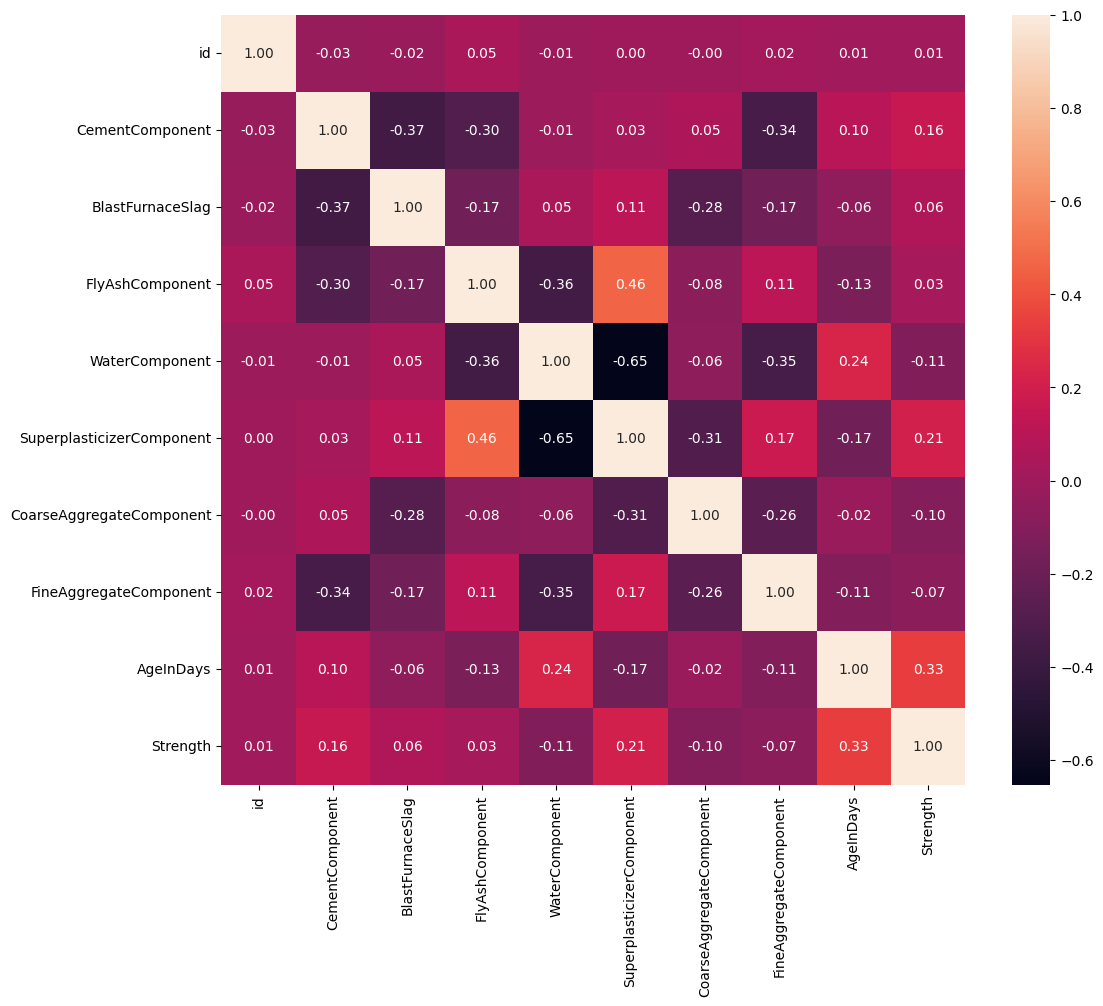

In [ ]:
corr_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

In [ ]:
df.describe()

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
count,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000
mean,2703.000000,299.168189,58.610579,31.872795,185.076235,4.108441,992.000718,771.219974,51.751618,35.452071
std,1561.010784,105.537682,83.417801,54.605003,18.517583,5.692296,77.148010,78.725253,70.006975,16.401896
min,0.000000,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,1351.500000,213.700000,0.000000,0.000000,175.100000,0.000000,938.200000,734.300000,7.000000,23.640000
50%,2703.000000,297.200000,0.000000,0.000000,187.400000,0.000000,978.000000,781.200000,28.000000,33.950000
75%,4054.500000,375.000000,122.600000,79.000000,192.000000,8.050000,1047.000000,821.000000,56.000000,45.850000
max,5406.000000,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


# Baseline - решение

In [3]:
df = pd.read_csv("/content/drive/MyDrive/playground-series-s3e9/train.csv")
result_test = pd.read_csv("/content/drive/MyDrive/playground-series-s3e9/test.csv")
result_indexes = result_test["id"]

In [4]:
train, test = train_test_split(df, test_size=0.2, random_state=43)
test, validate = train_test_split(test, test_size=0.25, random_state=43)

In [5]:
f'Shapes: train - {train.shape}, test - {test.shape}, validate - {validate.shape}, result_test - {result_test.shape}'

'Shapes: train - (4325, 10), test - (811, 10), validate - (271, 10), result_test - (3605, 9)'

### Разбиваем датасеты на идентификатор, фичи и таргет

In [6]:
train_labels = train['Strength']
test_labels = test['Strength']
validate_labels = validate['Strength']
train = train.drop(labels=['Strength'], axis=1)
test = test.drop(labels=['Strength'], axis=1)
validate = validate.drop(labels=['Strength'], axis=1)

### Feature Generation (basic)

In [7]:
poly = PolynomialFeatures(degree=2, include_bias=False)

train_poly = poly.fit_transform(train)
test_poly = poly.transform(test)
validate_poly = poly.transform(validate)
result_test_poly = poly.transform(result_test)

feature_names = poly.get_feature_names_out(input_features=train.columns)
train = pd.DataFrame(train_poly, columns=feature_names, index=train.index)
test = pd.DataFrame(test_poly, columns=feature_names, index=test.index)
validate = pd.DataFrame(validate_poly, columns=feature_names, index=validate.index)
result_test = pd.DataFrame(result_test_poly, columns=feature_names, index=result_test.index)

In [11]:
train.head()

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,id^2,...,SuperplasticizerComponent^2,SuperplasticizerComponent CoarseAggregateComponent,SuperplasticizerComponent FineAggregateComponent,SuperplasticizerComponent AgeInDays,CoarseAggregateComponent^2,CoarseAggregateComponent FineAggregateComponent,CoarseAggregateComponent AgeInDays,FineAggregateComponent^2,FineAggregateComponent AgeInDays,AgeInDays^2
279,279.0,350.0,0.0,0.0,203.0,0.0,974.0,775.0,90.0,77841.0,...,0.00,0.00,0.00,0.0,948676.00,754850.00,87660.0,600625.00,69750.0,8100.0
3714,3714.0,212.1,0.0,121.6,180.3,5.7,1057.6,779.3,100.0,13793796.0,...,32.49,6028.32,4442.01,570.0,1118517.76,824187.68,105760.0,607308.49,77930.0,10000.0
1497,1497.0,339.2,0.0,0.0,185.7,0.0,1069.2,754.3,28.0,2241009.0,...,0.00,0.00,0.00,0.0,1143188.64,806497.56,29937.6,568968.49,21120.4,784.0
4432,4432.0,425.0,0.0,0.0,153.5,16.5,852.1,887.1,3.0,19642624.0,...,272.25,14059.65,14637.15,49.5,726074.41,755897.91,2556.3,786946.41,2661.3,9.0
4183,4183.0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28.0,17497489.0,...,6.25,2600.00,1690.00,70.0,1081600.00,703040.00,29120.0,456976.00,18928.0,784.0


In [15]:
categorical_features = ["AgeInDays", "AgeInDays^2"]
real_features = [feature for feature in train.columns.tolist() if feature not in categorical_features]

### Кодирование категориальных столбцов (базовым OneHotEncoder)

In [18]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

ohe = encoder.fit(train[categorical_features])
ohe_train = ohe.transform(train[categorical_features])
ohe_test = ohe.transform(test[categorical_features])
ohe_validate = ohe.transform(validate[categorical_features])
ohe_result_test = ohe.transform(result_test[categorical_features])

# Получаем имена новых столбцов
ohe_columns = ohe.get_feature_names_out(categorical_features)

# Создаем новые DataFrame для one-hot закодированных данных
ohe_train_df = pd.DataFrame(ohe_train, columns=ohe_columns, index=train.index)
ohe_test_df = pd.DataFrame(ohe_test, columns=ohe_columns, index=test.index)
ohe_validate_df = pd.DataFrame(ohe_validate, columns=ohe_columns, index=validate.index)
ohe_result_test_df = pd.DataFrame(ohe_result_test, columns=ohe_columns, index=result_test.index)

# Убираем старые категориальные столбцы и добавляем новые
train.drop(columns=categorical_features, inplace=True)
train = pd.concat([train, ohe_train_df], axis=1)

test.drop(columns=categorical_features, inplace=True)
test = pd.concat([test, ohe_test_df], axis=1)

validate.drop(columns=categorical_features, inplace=True)
validate = pd.concat([validate, ohe_validate_df], axis=1)

result_test.drop(columns=categorical_features, inplace=True)
result_test = pd.concat([result_test, ohe_result_test_df], axis=1)

### Нормализация данных

In [19]:
scaler = StandardScaler()

train_real = train[real_features]
test_real = test[real_features]
validate_real = validate[real_features]
result_test_real = result_test[real_features]

train_real = pd.DataFrame(scaler.fit_transform(train_real), columns=real_features, index=train.index)
test_real = pd.DataFrame(scaler.transform(test_real), columns=real_features, index=test.index)
validate_real = pd.DataFrame(scaler.transform(validate_real), columns=real_features, index=validate.index)
result_test_real = pd.DataFrame(scaler.transform(result_test_real), columns=real_features, index=result_test.index)

# Combine normalized real features back with the rest of the data
train.update(train_real)
test.update(test_real)
validate.update(validate_real)
result_test.update(result_test_real)

In [20]:
train.head(5)

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,id^2,id CementComponent,...,AgeInDays^2_784.0,AgeInDays^2_3136.0,AgeInDays^2_8100.0,AgeInDays^2_8281.0,AgeInDays^2_10000.0,AgeInDays^2_14400.0,AgeInDays^2_32400.0,AgeInDays^2_72900.0,AgeInDays^2_129600.0,AgeInDays^2_133225.0
279,-1.549594,0.491762,-0.711632,-0.579705,0.974541,-0.716721,-0.230641,0.048232,-1.111350,-1.253893,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3714,0.640786,-0.818250,-0.711632,1.657379,-0.261313,0.283031,0.845619,0.102778,0.456765,-0.030052,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1497,-0.772918,0.389165,-0.711632,-0.579705,0.032678,-0.716721,0.994956,-0.214352,-0.864040,-0.526543,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4432,1.098630,1.204241,-0.711632,-0.579705,-1.720384,2.177299,-1.799972,1.470244,1.125449,1.913405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4183,0.939851,2.296709,-0.711632,-0.579705,-1.257619,-0.278233,0.619038,-1.207604,0.880200,2.578840,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Берем модель градиентного бустинга (CatBoost) и оптимизиурем гиперпараметры с помощью optuna на validate

In [21]:
ct_f = ['AgeInDays_1',
       'AgeInDays_3', 'AgeInDays_7', 'AgeInDays_14', 'AgeInDays_28',
       'AgeInDays_49', 'AgeInDays_56', 'AgeInDays_90', 'AgeInDays_91',
       'AgeInDays_100', 'AgeInDays_120', 'AgeInDays_180', 'AgeInDays_270',
       'AgeInDays_360', 'AgeInDays_365']

def objective(trial):
    param = {
        'iterations': 1000,
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
        'depth': trial.suggest_int('depth', 4, 10),
        'random_seed': 42,
        'logging_level': 'Silent',
        'early_stopping_rounds': 100,
        'eval_metric': 'RMSE'
    }

    catboost = CatBoostRegressor(**param)
    catboost.fit(train, train_labels, eval_set=(validate, validate_labels))

    preds = catboost.predict(validate)

    rmse = root_mean_squared_error(validate_labels, preds)

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=600)

print("Лучшие параметры: ", study.best_params)
print("Лучший RMSE: ", study.best_value)

best_params = study.best_params
catboost = CatBoostRegressor(iterations=2000,
                               learning_rate=best_params['learning_rate'],
                               depth=best_params['depth'],
                               random_seed=42,
                               logging_level='Silent',
                               early_stopping_rounds=100,
                               eval_metric='RMSE')
catboost.fit(train, train_labels, eval_set=(test, test_labels))

# Оценка финальной модели на тестовом наборе
final_preds = catboost.predict(test)
final_rmse = root_mean_squared_error(test_labels, final_preds)
print("Финальный RMSE на тесте: ", final_rmse)

catboost_solution = pd.DataFrame({
    'target': test_labels,
    'Strength': final_preds
})

[I 2024-12-02 09:24:59,125] A new study created in memory with name: no-name-938446a9-414e-4b03-aa52-f955c7994d17
[I 2024-12-02 09:25:05,826] Trial 0 finished with value: 11.924337702415407 and parameters: {'learning_rate': 0.1475662337387328, 'depth': 8}. Best is trial 0 with value: 11.924337702415407.
[I 2024-12-02 09:25:15,071] Trial 1 finished with value: 11.827659871621755 and parameters: {'learning_rate': 0.05253130659744822, 'depth': 7}. Best is trial 1 with value: 11.827659871621755.
[I 2024-12-02 09:25:43,325] Trial 2 finished with value: 12.049652752155502 and parameters: {'learning_rate': 0.0658773443867544, 'depth': 10}. Best is trial 1 with value: 11.827659871621755.
[I 2024-12-02 09:26:00,401] Trial 3 finished with value: 12.44275625588579 and parameters: {'learning_rate': 0.0016437646716748902, 'depth': 6}. Best is trial 1 with value: 11.827659871621755.
[I 2024-12-02 09:26:19,996] Trial 4 finished with value: 12.067266340885405 and parameters: {'learning_rate': 0.186976

Лучшие параметры:  {'learning_rate': 0.05464950301317028, 'depth': 6}
Лучший RMSE:  11.754612252105227
Финальный RMSE на тесте:  12.031821016233478


In [22]:
result = pd.DataFrame({
    'id': result_indexes,
    'Strength': catboost.predict(result_test)
}).set_index('id')
result.head()

,Strength
id,
5407,47.603121
5408,19.462224
5409,34.636312
5410,48.028586
5411,32.893171


In [23]:
result.to_csv("kaggle_baseline.csv")

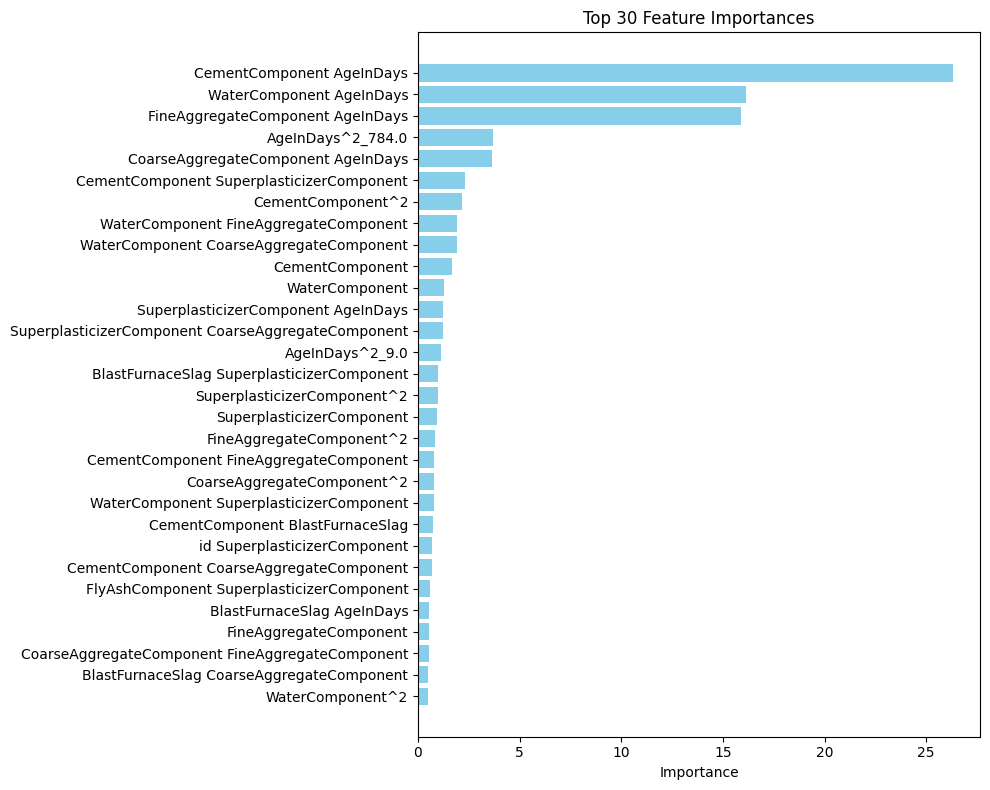

In [24]:
feature_importances = catboost.get_feature_importance()
feature_names = train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

top_30_features = feature_importance_df.head(30)

plt.figure(figsize=(10, 8))
plt.barh(top_30_features['Feature'], top_30_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Что заметил в baseline-решении

1. Некоторые значения AgeInDays редко встречаются + у них не высокий Feature  Importance, значит возникает идея их как-то объединить и нагенерить фичи в зависимости от отсечек по AgeInDays

2. У некоторых фич куча значений равных 0, поэтому есть идея сгенерить категориальные фичи на равенство нулю

3. Метрики очень сильно отличаются даже от random_state в сплите на трейн и тест, значит очень важно использовать кросс-валидацию в нашем датасете

**Result: private score in Kaggle - 12.30736**

![](images/baseline_solution.png)

# Fixed models

In [29]:
df = pd.read_csv("/content/drive/MyDrive/playground-series-s3e9/train.csv")
result_test = pd.read_csv("/content/drive/MyDrive/playground-series-s3e9/test.csv")
result_indexes = result_test["id"]

In [30]:
train, validate = train_test_split(df, test_size=0.2, random_state=42)

In [31]:
f'Shapes: train - {train.shape}, validate - {validate.shape}, result_test - {result_test.shape}'

'Shapes: train - (4325, 10), validate - (1082, 10), result_test - (3605, 9)'

## Feature Engineering

Описание полей:

- **id**: Идентификатор
- **CementComponent**: Количество добавленного цемента
- **BlastFurnaceSlag**: Количество добавленного доменного шлака
- **FlyAshComponent**: Количество добавленной летучей золы
- **WaterComponent**: Количество добавленной воды
- **SuperplasticizerComponent**: Количество добавленного суперпластификатора
- **CoarseAggregateComponent**: Количество добавленного крупного заполнителя
- **FineAggregateComponent**: Количество добавленного мелкого заполнителя
- **AgeInDays**: Сколько дней было оставлено на высыхание
- **Strength**: Какая была конечная прочность бетона (целевая)

In [32]:
train_labels = train['Strength']
validate_labels = validate['Strength']
train = train.drop(labels=['Strength'], axis=1)
validate = validate.drop(labels=['Strength'], axis=1)

In [33]:
top_30_features_list = [
 'AgeInDays^2',
 'CementComponent AgeInDays',
 'WaterComponent AgeInDays',
 'FineAggregateComponent AgeInDays',
 'CoarseAggregateComponent AgeInDays',
 'CementComponent SuperplasticizerComponent',
 'CementComponent^2',
 'WaterComponent FineAggregateComponent',
 'WaterComponent CoarseAggregateComponent',
 'CementComponent',
 'WaterComponent',
 'SuperplasticizerComponent AgeInDays',
 'SuperplasticizerComponent CoarseAggregateComponent',
 'BlastFurnaceSlag SuperplasticizerComponent',
 'SuperplasticizerComponent^2',
 'SuperplasticizerComponent',
 'FineAggregateComponent^2',
 'CementComponent FineAggregateComponent',
 'CoarseAggregateComponent^2',
 'WaterComponent SuperplasticizerComponent',
 'CementComponent BlastFurnaceSlag',
 'id SuperplasticizerComponent',
 'CementComponent CoarseAggregateComponent',
 'FlyAshComponent SuperplasticizerComponent',
 'BlastFurnaceSlag AgeInDays',
 'FineAggregateComponent',
 'CoarseAggregateComponent FineAggregateComponent',
 'BlastFurnaceSlag CoarseAggregateComponent',
 'WaterComponent^2']

In [34]:
poly = PolynomialFeatures(degree=2, include_bias=False)

train_poly = poly.fit_transform(train)
validate_poly = poly.transform(validate)
result_test_poly = poly.transform(result_test)

feature_names = poly.get_feature_names_out(input_features=train.columns)

train_poly_df = pd.DataFrame(train_poly, columns=feature_names, index=train.index)
validate_poly_df = pd.DataFrame(validate_poly, columns=feature_names, index=validate.index)
result_test_poly_df = pd.DataFrame(result_test_poly, columns=feature_names, index=result_test.index)

train_poly_top_30 = train_poly_df[top_30_features_list]
validate_poly_top_30 = validate_poly_df[top_30_features_list]
result_test_poly_top_30 = result_test_poly_df[top_30_features_list]

train_combined = pd.concat([train, train_poly_top_30], axis=1)
validate_combined = pd.concat([validate, validate_poly_top_30], axis=1)
result_test_combined = pd.concat([result_test, result_test_poly_top_30], axis=1)

In [35]:
train = pd.concat([train_combined, train_labels], axis=1)
validate= pd.concat([validate_combined, validate_labels], axis=1)
result_test = result_test_combined

In [36]:
train = train.loc[:, ~train.columns.duplicated()]
validate = validate.loc[:, ~validate.columns.duplicated()]
result_test = result_test.loc[:, ~result_test.columns.duplicated()]

In [37]:
for df in [train, validate, result_test]:
    df['Age_Water'] = df['AgeInDays'] / df['WaterComponent']
    df['Age_Cement'] = df['AgeInDays'] / df['CementComponent']
    df['Coarse_Fine'] = df['CoarseAggregateComponent'] / df['FineAggregateComponent']
    df['youngCementComponent'] = df.CementComponent * (df.AgeInDays < 40)
    df['youngSuperplasticizerComponent'] = df.SuperplasticizerComponent * (df.AgeInDays < 10)
    df['clippedAge'] = df.AgeInDays.clip(None, 40)
    df['clippedWater'] = df.WaterComponent.clip(195, None)
    df['hasBlastFurnaceSlag'] = (df['BlastFurnaceSlag'] != 0).astype(int)
    df['hasFlyAshComponent'] = (df.FlyAshComponent != 0).astype(int)
    df['hasSuperplasticizerComponent'] = (df.SuperplasticizerComponent != 0).astype(int)

In [39]:
def replace_some_age(x):
    replacements = {1: 3, 11: 14, 49: 56, 360: 365}
    return replacements.get(x)

train['AgeInDays'] = train['AgeInDays'].apply(lambda x: replace_some_age(x) if replace_some_age(x) is not None else x)
validate['AgeInDays'] = validate['AgeInDays'].apply(lambda x: replace_some_age(x) if replace_some_age(x) is not None else x)
result_test['AgeInDays'] = result_test['AgeInDays'].apply(lambda x: replace_some_age(x) if replace_some_age(x) is not None else x)

In [40]:
train.head()

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,AgeInDays^2,...,Age_Water,Age_Cement,Coarse_Fine,youngCementComponent,youngSuperplasticizerComponent,clippedAge,clippedWater,hasBlastFurnaceSlag,hasFlyAshComponent,hasSuperplasticizerComponent
5173,5173,277.1,0.0,97.4,160.6,11.8,973.9,875.6,28,784.0,...,0.174346,0.101047,1.112266,277.1,0.0,28,195.0,0,1,1
3288,3288,425.0,106.3,0.0,151.4,18.6,936.0,803.7,7,49.0,...,0.046235,0.016471,1.164614,425.0,18.6,7,195.0,1,0,1
1010,1010,362.6,189.0,0.0,164.9,11.6,944.7,755.8,91,8281.0,...,0.551850,0.250965,1.249934,0.0,0.0,40,195.0,1,0,1
1029,1029,349.0,0.0,0.0,192.0,0.0,1047.0,806.0,7,49.0,...,0.036458,0.020057,1.299007,349.0,0.0,7,195.0,0,0,0
4665,4665,339.0,0.0,0.0,197.0,0.0,968.0,781.0,28,784.0,...,0.142132,0.082596,1.239437,339.0,0.0,28,197.0,0,0,0


In [41]:
train.columns

Index(['id', 'CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
       'WaterComponent', 'SuperplasticizerComponent',
       'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays',
       'AgeInDays^2', 'CementComponent AgeInDays', 'WaterComponent AgeInDays',
       'FineAggregateComponent AgeInDays',
       'CoarseAggregateComponent AgeInDays',
       'CementComponent SuperplasticizerComponent', 'CementComponent^2',
       'WaterComponent FineAggregateComponent',
       'WaterComponent CoarseAggregateComponent',
       'SuperplasticizerComponent AgeInDays',
       'SuperplasticizerComponent CoarseAggregateComponent',
       'BlastFurnaceSlag SuperplasticizerComponent',
       'SuperplasticizerComponent^2', 'FineAggregateComponent^2',
       'CementComponent FineAggregateComponent', 'CoarseAggregateComponent^2',
       'WaterComponent SuperplasticizerComponent',
       'CementComponent BlastFurnaceSlag', 'id SuperplasticizerComponent',
       'CementComponent CoarseAg

In [42]:
categorical_features = ["AgeInDays", "AgeInDays^2", 'clippedAge', 'hasBlastFurnaceSlag',
                        'hasFlyAshComponent', 'hasSuperplasticizerComponent']
real_features = [feature for feature in result_test.columns.tolist() if feature not in categorical_features]
target = 'Strength'

In [43]:
categorical_features

['AgeInDays',
 'AgeInDays^2',
 'clippedAge',
 'hasBlastFurnaceSlag',
 'hasFlyAshComponent',
 'hasSuperplasticizerComponent']

In [44]:
real_features

['id',
 'CementComponent',
 'BlastFurnaceSlag',
 'FlyAshComponent',
 'WaterComponent',
 'SuperplasticizerComponent',
 'CoarseAggregateComponent',
 'FineAggregateComponent',
 'CementComponent AgeInDays',
 'WaterComponent AgeInDays',
 'FineAggregateComponent AgeInDays',
 'CoarseAggregateComponent AgeInDays',
 'CementComponent SuperplasticizerComponent',
 'CementComponent^2',
 'WaterComponent FineAggregateComponent',
 'WaterComponent CoarseAggregateComponent',
 'SuperplasticizerComponent AgeInDays',
 'SuperplasticizerComponent CoarseAggregateComponent',
 'BlastFurnaceSlag SuperplasticizerComponent',
 'SuperplasticizerComponent^2',
 'FineAggregateComponent^2',
 'CementComponent FineAggregateComponent',
 'CoarseAggregateComponent^2',
 'WaterComponent SuperplasticizerComponent',
 'CementComponent BlastFurnaceSlag',
 'id SuperplasticizerComponent',
 'CementComponent CoarseAggregateComponent',
 'FlyAshComponent SuperplasticizerComponent',
 'BlastFurnaceSlag AgeInDays',
 'CoarseAggregateCompone

In [45]:
target

'Strength'

## Feature Jittering

In [48]:
def apply_feature_jittering(X, jitter_std=0.01):
    """
    Добавляет случайный шум к числовым признакам.
    X: Входные признаки
    jitter_std: Стандартное отклонение для нормального шума
    return: DataFrame с зашумленными признаками
    """
    noise = np.random.normal(0, jitter_std, X.shape)
    X_jittered = X + noise
    return X_jittered

# Обычно feature jittering применяется только к train выборке
# Не применяется к категориальным признакам
X_train_real = train[real_features]
X_train_cat = train[categorical_features]
X_train_jittered = apply_feature_jittering(X_train_real, jitter_std=0.05)

# Применяем jittering к обучающим данным
# По хорошему надо смотреть дисперсию каждого признака и на её основе выбирать jitter_std
# Но это слишком запарно
X_train_jittered_df = pd.DataFrame(X_train_jittered, columns=real_features)
train = pd.concat([X_train_jittered_df, X_train_cat], axis=1)

In [53]:
train = pd.concat([train, train_labels], axis=1)

## Pseudo Labeling

In [ ]:
X_unlabeled = result_test # Данные без разметки

# Обучение модели на размеченных данных
model = CatBoostRegressor(*best_params)
model.fit(X_train, y_train)

# Предсказание псевдометок для неразмеченных данных
pseudo_labels = model.predict(X_unlabeled)

# Фильтрация данных с высокой уверенностью
# В данном случае мы можем использовать, например, дисперсию предсказаний как метрику уверенности.
# Честно говоря не уверен как отбирают данные для регрессии, с классификацией все понятнее.
threshold = 0.1  # Пример: условный порог
confident_indices = np.abs(pseudo_labels - pseudo_labels.mean()) < threshold
X_pseudo = X_unlabeled[confident_indices]
y_pseudo = pseudo_labels[confident_indices]

print(f"Используем {len(X_pseudo)} псевдометок из {len(X_unlabeled)}")

# Объединяем размеченные и псевдоразмеченные данные
X_combined = np.vstack((X_train, X_pseudo))
y_combined = np.vstack((y_train, y_pseudo))

# Повторное обучение на объедененных данных
model.fit(X_combined, y_combined)

## Кросс-валидация для получения скора

In [54]:
def train_and_validate_fold(model, X_tr, X_va, y_tr, y_va):
    model.fit(X_tr, y_tr)
    trmse = root_mean_squared_error(y_tr, model.predict(X_tr))
    y_va_pred = model.predict(X_va)
    rmse = root_mean_squared_error(y_va, y_va_pred)
    return trmse, rmse, y_va_pred

def calculate_and_print_rmse(score_list, label=None):
    rmse = sum(score_list) / len(score_list)
    print(f"Average rmse in all folds: {rmse:.3f} with {label}")
    return rmse

def get_cross_validation_score_of_model(model, features_used, label=None):
    score_list = []
    oof = np.zeros_like(train[target])
    kf = KFold(shuffle=True, random_state=333)
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train, groups=train[categorical_features + real_features].apply(tuple, axis=1))):
        X_tr = train.iloc[idx_tr][features_used]
        X_va = train.iloc[idx_va][features_used]
        y_tr = train.iloc[idx_tr][target]
        y_va = train.iloc[idx_va][target]
        trmse, rmse, y_va_pred = train_and_validate_fold(model, X_tr, X_va, y_tr, y_va)

        print(f"Number fold {fold} - train_rmse = {trmse:.3f} and rmse = {rmse:.3f}")
        oof[idx_va] = y_va_pred
        score_list.append(rmse)

    rmse = calculate_and_print_rmse(score_list, label)

## Voting Boostings + RandomForest + LinReg with TargetEncoder()

In [55]:
def create_gb_pipeline(target_encoder, categorical_features, real_features, gbr_params):
    """Creates a pipeline for Gradient Boosting Regressor."""
    transformers = [
        ('target_enc', target_encoder, categorical_features),
        ('scaler', StandardScaler(), real_features)
    ]
    return make_pipeline(
        ColumnTransformer(transformers),
        GradientBoostingRegressor(**gbr_params, random_state=42)
    )

def create_lgbm_pipeline(target_encoder, categorical_features, real_features, lgbm_params):
    """Creates a pipeline for LightGBM Regressor."""
    transformers = [
        ('target_enc', target_encoder, categorical_features),
        ('scaler', StandardScaler(), real_features)
    ]
    return make_pipeline(
        ColumnTransformer(transformers),
        lgb.LGBMRegressor(**lgbm_params, random_state=42)
    )

def create_rf_pipeline(target_encoder, categorical_features, real_features):
    """Creates a pipeline for Random Forest Regressor."""
    transformers = [
        ('target_enc', target_encoder, categorical_features),
        ('scaler', StandardScaler(), real_features)
    ]
    return make_pipeline(
        ColumnTransformer(transformers),
        RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=42)
    )

def create_ridge_pipeline(target_encoder, categorical_features, real_features):
    """Creates a pipeline for Ridge Regressor."""
    transformers = [
        ('target_enc', target_encoder, categorical_features),
        ('scaler', StandardScaler(), real_features)
    ]
    return make_pipeline(
        ColumnTransformer(transformers),
        Ridge(30)
    )

def create_ensemble_model(target_encoder, categorical_features, real_features, gbr_params, lgbm_params):
    """Creates an ensemble model joining various regressors."""
    return VotingRegressor(
        estimators=[
            ('gb', create_gb_pipeline(target_encoder, categorical_features, real_features, gbr_params)),
            ('lgbm', create_lgbm_pipeline(target_encoder, categorical_features, real_features, lgbm_params)),
            ('rf', create_rf_pipeline(target_encoder, categorical_features, real_features)),
            ('ridge', create_ridge_pipeline(target_encoder, categorical_features, real_features))
        ],
        weights=[0.2, 0.2, 0.3, 0.3]
    )

lgbm_params = {
    'learning_rate': 0.0005,
    'n_estimators': 20000,
    'num_leaves': 7,
    'colsample_bytree': 0.4,
    'subsample': 0.5,
    'subsample_freq': 6,
    'min_child_samples': 25,
}
gbr_params = {
    'n_estimators': 600,
    'max_depth': 4,
    'learning_rate': 0.01,
    'min_samples_leaf': 40 ,
    'max_features': 3
}

target_encoder = TargetEncoder()
ensemble_model = create_ensemble_model(target_encoder, categorical_features, real_features, gbr_params, lgbm_params)

get_cross_validation_score_of_model(
    model=ensemble_model,
    features_used=categorical_features + real_features,
    label='GradientBoostingRegressor + LGBM + RF + Ridge'
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9871
[LightGBM] [Info] Number of data points in the train set: 3460, number of used features: 44
[LightGBM] [Info] Start training from score 35.722295
Number fold 0 - train_rmse = 11.397 and rmse = 11.959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9869
[LightGBM] [Info] Number of data points in the train set: 3460, number of used features: 44
[LightGBM] [Info] Start training from score 35.456379
Number fold 1 - train_rmse = 11.246 and rmse = 12.582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001599 seconds.
You can set `force_col_wise=true` to rem

In [56]:
ensemble_model.fit(train[result_test.columns], train[target])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9870
[LightGBM] [Info] Number of data points in the train set: 4325, number of used features: 44
[LightGBM] [Info] Start training from score 35.610666


VotingRegressor(estimators=[('gb',
                             Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('target_enc',
                                                                               TargetEncoder(),
                                                                               ['AgeInDays',
                                                                                'AgeInDays^2',
                                                                                'clippedAge',
                                                                                'hasBlastFurnaceSlag',
                                                                                'hasFlyAshComponent',
                                                                                'hasSuperplasticizerComponent']),
                                                                              ('scaler',
                                                                               StandardScaler(),
                                                                               ['id',
                                                                                'CementComponent',
                                                                                'BlastFurnaceSlag',
                                                                                'FlyAshComponent',
                                                                                'WaterCompone...
                                                                                'CoarseAggregateComponent^2',
                                                                                'WaterComponent '
                                                                                'SuperplasticizerComponent',
                                                                                'CementComponent '
                                                                                'BlastFurnaceSlag',
                                                                                'id '
                                                                                'SuperplasticizerComponent',
                                                                                'CementComponent '
                                                                                'CoarseAggregateComponent',
                                                                                'FlyAshComponent '
                                                                                'SuperplasticizerComponent',
                                                                                'BlastFurnaceSlag '
                                                                                'AgeInDays',
                                                                                'CoarseAggregateComponent '
                                                                                'FineAggregateComponent', ...])])),
                                             ('ridge', Ridge(alpha=30))]))],
                weights=[0.2, 0.2, 0.3, 0.3])

In [57]:
result = pd.DataFrame({
    'id': result_indexes,
    'Strength': ensemble_model.predict(result_test)
}).set_index('id')
result.head()

,Strength
id,
5407,47.985950
5408,19.421173
5409,34.766965
5410,48.645943
5411,34.191089


In [58]:
result.to_csv("kaggle_first_solution.csv")

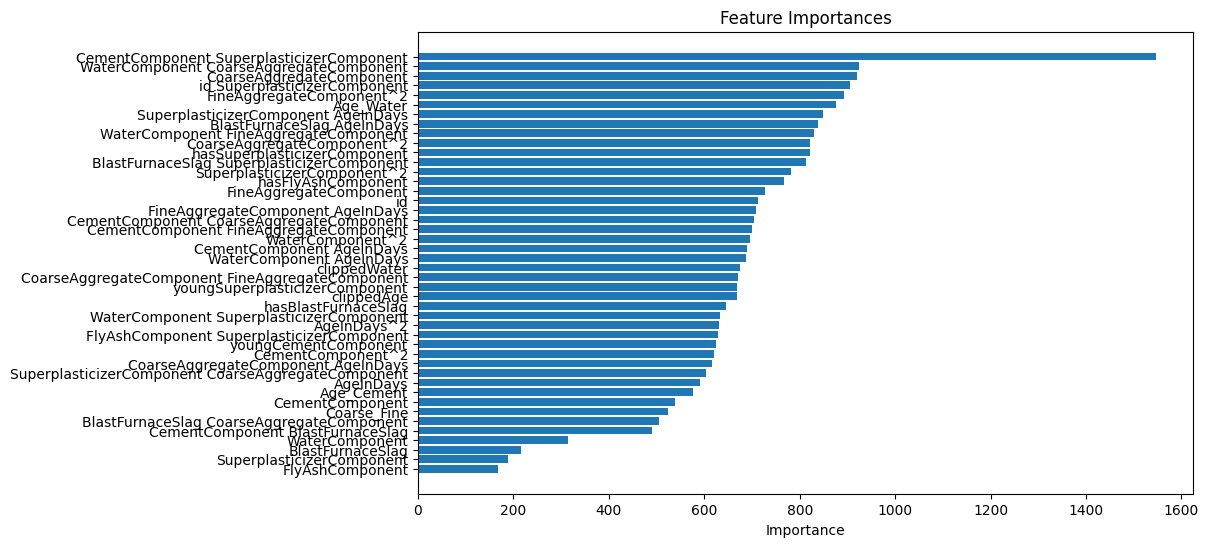

In [59]:
estimators = ensemble_model.named_estimators_
feature_importance_dict = {}

for name, est in estimators.items():
    if hasattr(est[-1], 'feature_importances_'):
        feature_importance_dict[name] = est[-1].feature_importances_
    elif hasattr(est[-1], 'coef_'):
        feature_importance_dict[name] = np.abs(est[-1].coef_)

average_feature_importance = np.mean(list(feature_importance_dict.values()), axis=0)
feature_importances = average_feature_importance
feature_names = result_test.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

**Without Feature Jittering**

![](images/first_solution.png)

**Result: private score in Kaggle - 12.24752**

**With Feature Jittering**

![](images/solution_with_jittering.png)

**Result: private score in Kaggle - 12.22269**

## Voting Boostings + RandomForest + LinReg with TargetEncoder + OneHotEncoder

In [26]:
def create_gb_pipeline(target_encoder, categorical_features, real_features, gbr_params):
    """Создает pipeline для Gradient Boosting Regressor с двумя типами кодировок."""
    transformers = [
        ('target_enc', target_encoder, categorical_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('scaler', StandardScaler(), real_features)
    ]
    return make_pipeline(
        ColumnTransformer(transformers),
        GradientBoostingRegressor(**gbr_params, random_state=42)
    )

def create_lgbm_pipeline(target_encoder, categorical_features, real_features, lgbm_params):
    """Создает pipeline для LightGBM Regressor."""
    transformers = [
        ('target_enc', target_encoder, categorical_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('scaler', StandardScaler(), real_features)
    ]
    return make_pipeline(
        ColumnTransformer(transformers),
        lgb.LGBMRegressor(**lgbm_params, random_state=42)
    )

def create_rf_pipeline(target_encoder, categorical_features, real_features):
    """Создает pipeline для Random Forest Regressor."""
    transformers = [
        ('target_enc', target_encoder, categorical_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('scaler', StandardScaler(), real_features)
    ]
    return make_pipeline(
        ColumnTransformer(transformers),
        RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=42)
    )

def create_ridge_pipeline(target_encoder, categorical_features, real_features):
    """Создает pipeline для Ridge Regressor."""
    transformers = [
        ('target_enc', target_encoder, categorical_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('scaler', StandardScaler(), real_features)
    ]
    return make_pipeline(
        ColumnTransformer(transformers),
        Ridge(30)
    )

def create_ensemble_model(target_encoder, categorical_features, real_features, gbr_params, lgbm_params):
    """Creates an ensemble model joining various regressors."""
    return VotingRegressor(
        estimators=[
            ('gb', create_gb_pipeline(target_encoder, categorical_features, real_features, gbr_params)),
            ('lgbm', create_lgbm_pipeline(target_encoder, categorical_features, real_features, lgbm_params)),
            ('rf', create_rf_pipeline(target_encoder, categorical_features, real_features)),
            ('ridge', create_ridge_pipeline(target_encoder, categorical_features, real_features))
        ],
        weights=[0.2, 0.2, 0.3, 0.3]
    )


lgbm_params = {
    'learning_rate': 0.0005,
    'n_estimators': 20000,
    'num_leaves': 7,
    'colsample_bytree': 0.4,
    'subsample': 0.5,
    'subsample_freq': 6,
    'min_child_samples': 25,
}
gbr_params = {
    'n_estimators': 600,
    'max_depth': 4,
    'learning_rate': 0.01,
    'min_samples_leaf': 40 ,
    'max_features': 3
}

target_encoder = TargetEncoder()
ensemble_model = create_ensemble_model(target_encoder, categorical_features, real_features, gbr_params, lgbm_params)

get_cross_validation_score_of_model(
    model=ensemble_model,
    features_used=categorical_features + real_features,
    label='GradientBoostingRegressor + LGBM + RF + Ridge'
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8235
[LightGBM] [Info] Number of data points in the train set: 3460, number of used features: 78
[LightGBM] [Info] Start training from score 35.722295
Number fold 0 - train_rmse = 11.599 and rmse = 11.911
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8227
[LightGBM] [Info] Number of data points in the train set: 3460, number of used features: 77
[LightGBM] [Info] Start training from score 35.456379
Number fold 1 - train_rmse = 11.428 and rmse = 12.563
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testin

In [27]:
ensemble_model.fit(train[result_test.columns], train[target])
result = pd.DataFrame({
    'id': result_indexes,
    'Strength': ensemble_model.predict(result_test)
}).set_index('id')
result.head()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8343
[LightGBM] [Info] Number of data points in the train set: 4325, number of used features: 78
[LightGBM] [Info] Start training from score 35.610666


,Strength
id,
5407,47.760970
5408,19.676934
5409,35.057800
5410,49.248542
5411,33.437033


In [114]:
result.to_csv("kaggle_second_solution.csv")

**Without Feature Jittering**

![](images/second_solution.png)

**Result: private score in Kaggle - 12.24069.**

**Этот результат уже попадает в топ распределения**

**With Feature Jittering**

![](images/second_solution_with_jittering.png)

**Result: private score in Kaggle - 12.22049.**

**Вывод:** это уже топ-2 результат.

## Steking by Boostings + RandomForest + LinReg with TargetEncoder + OneHotEncoder

In [ ]:
def create_gb_pipeline(target_encoder, categorical_features, real_features, gbr_params):
    """Создает pipeline для Gradient Boosting Regressor с двумя типами кодировок."""
    transformers = [
        ('target_enc', target_encoder, categorical_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('scaler', StandardScaler(), real_features)
    ]
    return make_pipeline(
        ColumnTransformer(transformers),
        GradientBoostingRegressor(**gbr_params, random_state=42)
    )

def create_lgbm_pipeline(target_encoder, categorical_features, real_features, lgbm_params):
    """Создает pipeline для LightGBM Regressor."""
    transformers = [
        ('target_enc', target_encoder, categorical_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('scaler', StandardScaler(), real_features)
    ]
    return make_pipeline(
        ColumnTransformer(transformers),
        lgb.LGBMRegressor(**lgbm_params, random_state=42)
    )

def create_rf_pipeline(target_encoder, categorical_features, real_features):
    """Создает pipeline для Random Forest Regressor."""
    transformers = [
        ('target_enc', target_encoder, categorical_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('scaler', StandardScaler(), real_features)
    ]
    return make_pipeline(
        ColumnTransformer(transformers),
        RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=42)
    )

def create_ridge_pipeline(target_encoder, categorical_features, real_features):
    """Создает pipeline для Ridge Regressor."""
    transformers = [
        ('target_enc', target_encoder, categorical_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('scaler', StandardScaler(), real_features)
    ]
    return make_pipeline(
        ColumnTransformer(transformers),
        Ridge(30)
    )

def create_ensemble_model(target_encoder, categorical_features, real_features, gbr_params, lgbm_params):
    """Creates an ensemble model joining various regressors."""
    return StackingRegressor(
        estimators=[
            ('gb', create_gb_pipeline(target_encoder, categorical_features, real_features, gbr_params)),
            ('lgbm', create_lgbm_pipeline(target_encoder, categorical_features, real_features, lgbm_params)),
            ('rf', create_rf_pipeline(target_encoder, categorical_features, real_features)),
            ('ridge', create_ridge_pipeline(target_encoder, categorical_features, real_features))
        ]
    )


lgbm_params = {
    'learning_rate': 0.0005,
    'n_estimators': 20000,
    'num_leaves': 7,
    'colsample_bytree': 0.4,
    'subsample': 0.5,
    'subsample_freq': 6,
    'min_child_samples': 25,
}
gbr_params = {
    'n_estimators': 600,
    'max_depth': 4,
    'learning_rate': 0.01,
    'min_samples_leaf': 40 ,
    'max_features': 3
}

target_encoder = TargetEncoder()
ensemble_model = create_ensemble_model(target_encoder, categorical_features, real_features, gbr_params, lgbm_params)

get_cross_validation_score_of_model(
    model=ensemble_model,
    features_used=categorical_features + real_features,
    label='GradientBoostingRegressor + LGBM + RF + Ridge'
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2505
[LightGBM] [Info] Number of data points in the train set: 3460, number of used features: 41
[LightGBM] [Info] Start training from score 35.722295
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2448
[LightGBM] [Info] Number of data points in the train set: 2768, number of used features: 41
[LightGBM] [Info] Start training from score 35.670278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [ ]:
ensemble_model.fit(train[result_test.columns], train[target])
result = pd.DataFrame({
    'id': result_indexes,
    'Strength': ensemble_model.predict(result_test)
}).set_index('id')
result.head()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2559
[LightGBM] [Info] Number of data points in the train set: 4325, number of used features: 41
[LightGBM] [Info] Start training from score 35.610666
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2510
[LightGBM] [Info] Number of data points in the train set: 3460, number of used features: 41
[LightGBM] [Info] Start training from score 35.657093
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

,Strength
id,
5407,51.085095
5408,19.640763
5409,35.205476
5410,50.235434
5411,34.710047


In [ ]:
result.to_csv("kaggle_third_solution.csv")

## Optimaze hyperparameters

In [34]:
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def create_gb_objective(X, y, target_encoder, categorical_features, real_features):
    def objective(trial):
        gbr_params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 2, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 100),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        }

        model = create_gb_pipeline(target_encoder, categorical_features, real_features, gbr_params)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = mean_squared_error(y_test, y_pred)

        return score

    return objective

def create_lgbm_objective(X, y, target_encoder, categorical_features, real_features):
    def objective(trial):
        lgbm_params = {
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),
            'n_estimators': trial.suggest_int('n_estimators', 10000, 20000),
            'num_leaves': trial.suggest_int('num_leaves', 2, 20),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
            'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 20),
        }

        model = create_lgbm_pipeline(target_encoder, categorical_features, real_features, lgbm_params)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = mean_squared_error(y_test, y_pred)

        return score

    return objective

def create_rf_objective(X, y, target_encoder, categorical_features, real_features):
    def objective(trial):
        rf_params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100),
        }

        transformers = [
            ('target_enc', target_encoder, categorical_features),
            ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('scaler', StandardScaler(), real_features)
        ]
        model = make_pipeline(
            ColumnTransformer(transformers),
            RandomForestRegressor(**rf_params, random_state=42)
        )

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = mean_squared_error(y_test, y_pred)

        return score

    return objective

def create_ridge_objective(X, y, target_encoder, categorical_features, real_features):
    def objective(trial):
        ridge_alpha = trial.suggest_loguniform('alpha', 0.1, 100.0)

        transformers = [
            ('target_enc', target_encoder, categorical_features),
            ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('scaler', StandardScaler(), real_features)
        ]
        model = make_pipeline(
            ColumnTransformer(transformers),
            Ridge(ridge_alpha)
        )

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = mean_squared_error(y_test, y_pred)

        return score

    return objective

In [30]:
# Optimize Gradient Boosting Regressor
print("Optimizing Gradient Boosting Regressor...")
gb_study = optuna.create_study(direction='minimize')
gb_study.optimize(create_gb_objective(validate.drop(labels=['Strength'], axis=1), validate['Strength'], TargetEncoder(), categorical_features, real_features), n_trials=20)
gb_study.best_params

[I 2024-12-04 06:48:43,489] A new study created in memory with name: no-name-d34aafba-4e55-45cd-b75d-a38cc3612f3d


Optimizing Gradient Boosting Regressor...


[I 2024-12-04 06:48:44,009] Trial 0 finished with value: 160.92031104900886 and parameters: {'n_estimators': 254, 'max_depth': 4, 'learning_rate': 0.06562584644298257, 'min_samples_leaf': 96, 'max_features': 'log2'}. Best is trial 0 with value: 160.92031104900886.
[I 2024-12-04 06:48:44,763] Trial 1 finished with value: 236.49242085706396 and parameters: {'n_estimators': 405, 'max_depth': 7, 'learning_rate': 0.0010683497560824882, 'min_samples_leaf': 89, 'max_features': 'log2'}. Best is trial 0 with value: 160.92031104900886.
[I 2024-12-04 06:48:46,823] Trial 2 finished with value: 176.54621778571362 and parameters: {'n_estimators': 908, 'max_depth': 5, 'learning_rate': 0.0792408974565582, 'min_samples_leaf': 97, 'max_features': 'sqrt'}. Best is trial 0 with value: 160.92031104900886.
[I 2024-12-04 06:48:47,561] Trial 3 finished with value: 166.7807092984857 and parameters: {'n_estimators': 427, 'max_depth': 2, 'learning_rate': 0.09000740726270111, 'min_samples_leaf': 49, 'max_features

{'n_estimators': 139,
 'max_depth': 8,
 'learning_rate': 0.0312570823150976,
 'min_samples_leaf': 74,
 'max_features': 'sqrt'}

In [31]:
# Optimize Random Forest Regressor
print("Optimizing Random Forest Regressor...")
rf_study = optuna.create_study(direction='minimize')
rf_study.optimize(create_rf_objective(validate.drop(labels=['Strength'], axis=1), validate['Strength'], TargetEncoder(), categorical_features, real_features), n_trials=20)
rf_study.best_params

[I 2024-12-04 06:49:15,408] A new study created in memory with name: no-name-4dde97e0-5b75-4e57-bc2c-63d81e3e9260


Optimizing Random Forest Regressor...


[I 2024-12-04 06:49:19,588] Trial 0 finished with value: 167.74526450910415 and parameters: {'n_estimators': 407, 'max_depth': 8, 'min_samples_leaf': 33}. Best is trial 0 with value: 167.74526450910415.
[I 2024-12-04 06:49:21,934] Trial 1 finished with value: 181.34287960876915 and parameters: {'n_estimators': 285, 'max_depth': 3, 'min_samples_leaf': 82}. Best is trial 0 with value: 167.74526450910415.
[I 2024-12-04 06:49:32,738] Trial 2 finished with value: 168.93843042408622 and parameters: {'n_estimators': 912, 'max_depth': 6, 'min_samples_leaf': 9}. Best is trial 0 with value: 167.74526450910415.
[I 2024-12-04 06:49:36,245] Trial 3 finished with value: 165.6404406197211 and parameters: {'n_estimators': 403, 'max_depth': 9, 'min_samples_leaf': 23}. Best is trial 3 with value: 165.6404406197211.
[I 2024-12-04 06:49:39,802] Trial 4 finished with value: 166.64749713836645 and parameters: {'n_estimators': 439, 'max_depth': 12, 'min_samples_leaf': 28}. Best is trial 3 with value: 165.640

{'n_estimators': 403, 'max_depth': 9, 'min_samples_leaf': 23}

In [32]:
# Optimize Ridge Regressor
print("Optimizing Ridge Regressor...")
ridge_study = optuna.create_study(direction='minimize')
ridge_study.optimize(create_ridge_objective(validate.drop(labels=['Strength'], axis=1), validate['Strength'], TargetEncoder(), categorical_features, real_features), n_trials=20)
ridge_study.best_params

[I 2024-12-04 06:50:59,818] A new study created in memory with name: no-name-4232b5a3-a62c-43d6-835b-6bb149f0465c
[I 2024-12-04 06:50:59,863] Trial 0 finished with value: 168.94097009470465 and parameters: {'alpha': 0.13893810908268278}. Best is trial 0 with value: 168.94097009470465.
[I 2024-12-04 06:50:59,913] Trial 1 finished with value: 161.72585921304955 and parameters: {'alpha': 8.985413550575913}. Best is trial 1 with value: 161.72585921304955.
[I 2024-12-04 06:50:59,968] Trial 2 finished with value: 163.292513687439 and parameters: {'alpha': 4.190467120220265}. Best is trial 1 with value: 161.72585921304955.


Optimizing Ridge Regressor...


[I 2024-12-04 06:51:00,054] Trial 3 finished with value: 160.6585954485334 and parameters: {'alpha': 63.89350840980208}. Best is trial 3 with value: 160.6585954485334.
[I 2024-12-04 06:51:00,115] Trial 4 finished with value: 160.75036271914328 and parameters: {'alpha': 64.58101299218895}. Best is trial 3 with value: 160.6585954485334.
[I 2024-12-04 06:51:00,166] Trial 5 finished with value: 159.7794473252305 and parameters: {'alpha': 72.1929155251018}. Best is trial 5 with value: 159.7794473252305.
[I 2024-12-04 06:51:00,217] Trial 6 finished with value: 165.7806321172568 and parameters: {'alpha': 0.22096760221844466}. Best is trial 5 with value: 159.7794473252305.
[I 2024-12-04 06:51:00,280] Trial 7 finished with value: 165.68924142761966 and parameters: {'alpha': 0.23367945015443034}. Best is trial 5 with value: 159.7794473252305.
[I 2024-12-04 06:51:00,345] Trial 8 finished with value: 160.6829567852272 and parameters: {'alpha': 63.5348091310736}. Best is trial 5 with value: 159.779

{'alpha': 72.1929155251018}

In [35]:
# Optimize LightGBM Regressor
print("Optimizing LightGBM Regressor...")
lgbm_study = optuna.create_study(direction='minimize')
lgbm_study.optimize(create_lgbm_objective(validate.drop(labels=['Strength'], axis=1), validate['Strength'], TargetEncoder(), categorical_features, real_features), n_trials=10)
lgbm_study.best_params

[I 2024-12-04 06:52:29,944] A new study created in memory with name: no-name-06f50d5b-5096-40d9-b21d-31c5065ca5c8


Optimizing LightGBM Regressor...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5561
[LightGBM] [Info] Number of data points in the train set: 865, number of used features: 74
[LightGBM] [Info] Start training from score 34.189884


[I 2024-12-04 06:52:43,248] Trial 0 finished with value: 170.7507737672164 and parameters: {'learning_rate': 0.0005599202962409665, 'n_estimators': 19558, 'num_leaves': 9, 'colsample_bytree': 0.48666021547944094, 'subsample': 0.6107943851765016, 'min_child_samples': 14}. Best is trial 0 with value: 170.7507737672164.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5569
[LightGBM] [Info] Number of data points in the train set: 865, number of used features: 77
[LightGBM] [Info] Start training from score 34.189884


[I 2024-12-04 06:52:45,656] Trial 1 finished with value: 199.6535244368945 and parameters: {'learning_rate': 0.017390689959159385, 'n_estimators': 11712, 'num_leaves': 4, 'colsample_bytree': 0.2403479164025828, 'subsample': 0.30155693024144997, 'min_child_samples': 7}. Best is trial 0 with value: 170.7507737672164.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5569
[LightGBM] [Info] Number of data points in the train set: 865, number of used features: 77
[LightGBM] [Info] Start training from score 34.189884


[I 2024-12-04 06:52:51,266] Trial 2 finished with value: 172.93516531266616 and parameters: {'learning_rate': 0.007152649949158584, 'n_estimators': 17879, 'num_leaves': 2, 'colsample_bytree': 0.7292041119143077, 'subsample': 0.6367953722533799, 'min_child_samples': 10}. Best is trial 0 with value: 170.7507737672164.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5566
[LightGBM] [Info] Number of data points in the train set: 865, number of used features: 77
[LightGBM] [Info] Start training from score 34.189884


[I 2024-12-04 06:53:12,684] Trial 3 finished with value: 210.8993807088513 and parameters: {'learning_rate': 0.08120301020579966, 'n_estimators': 13069, 'num_leaves': 16, 'colsample_bytree': 0.7970553720689325, 'subsample': 0.27498391557207214, 'min_child_samples': 12}. Best is trial 0 with value: 170.7507737672164.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5562
[LightGBM] [Info] Number of data points in the train set: 865, number of used features: 74
[LightGBM] [Info] Start training from score 34.189884


[I 2024-12-04 06:53:28,684] Trial 4 finished with value: 168.36240514482967 and parameters: {'learning_rate': 0.0002664828725913837, 'n_estimators': 11389, 'num_leaves': 19, 'colsample_bytree': 0.5518713383801366, 'subsample': 0.2188357395390642, 'min_child_samples': 14}. Best is trial 4 with value: 168.36240514482967.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5557
[LightGBM] [Info] Number of data points in the train set: 865, number of used features: 72
[LightGBM] [Info] Start training from score 34.189884


[I 2024-12-04 06:53:46,377] Trial 5 finished with value: 199.77725032797554 and parameters: {'learning_rate': 0.003185589157775817, 'n_estimators': 12391, 'num_leaves': 16, 'colsample_bytree': 0.8455805637749966, 'subsample': 0.8231933087222922, 'min_child_samples': 18}. Best is trial 4 with value: 168.36240514482967.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5564
[LightGBM] [Info] Number of data points in the train set: 865, number of used features: 77
[LightGBM] [Info] Start training from score 34.189884


[I 2024-12-04 06:53:56,068] Trial 6 finished with value: 191.26084088631742 and parameters: {'learning_rate': 0.015320969387316695, 'n_estimators': 10977, 'num_leaves': 19, 'colsample_bytree': 0.2882804724377105, 'subsample': 0.596200755465569, 'min_child_samples': 7}. Best is trial 4 with value: 168.36240514482967.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5560
[LightGBM] [Info] Number of data points in the train set: 865, number of used features: 72
[LightGBM] [Info] Start training from score 34.189884


[I 2024-12-04 06:54:06,223] Trial 7 finished with value: 217.5269825323757 and parameters: {'learning_rate': 0.020200540031717614, 'n_estimators': 17037, 'num_leaves': 10, 'colsample_bytree': 0.428505597123208, 'subsample': 0.5680088542583316, 'min_child_samples': 18}. Best is trial 4 with value: 168.36240514482967.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5558
[LightGBM] [Info] Number of data points in the train set: 865, number of used features: 72
[LightGBM] [Info] Start training from score 34.189884


[I 2024-12-04 06:54:11,264] Trial 8 finished with value: 207.4676927897868 and parameters: {'learning_rate': 0.04062596170737256, 'n_estimators': 11042, 'num_leaves': 3, 'colsample_bytree': 0.9313451971631403, 'subsample': 0.9187251058809172, 'min_child_samples': 18}. Best is trial 4 with value: 168.36240514482967.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5573
[LightGBM] [Info] Number of data points in the train set: 865, number of used features: 77
[LightGBM] [Info] Start training from score 34.189884


[I 2024-12-04 06:54:16,645] Trial 9 finished with value: 223.54674397678383 and parameters: {'learning_rate': 0.056154838272042665, 'n_estimators': 15258, 'num_leaves': 5, 'colsample_bytree': 0.49874984350062956, 'subsample': 0.32088363279572835, 'min_child_samples': 8}. Best is trial 4 with value: 168.36240514482967.


{'learning_rate': 0.0002664828725913837,
 'n_estimators': 11389,
 'num_leaves': 19,
 'colsample_bytree': 0.5518713383801366,
 'subsample': 0.2188357395390642,
 'min_child_samples': 14}

In [36]:
def create_gb_pipeline(target_encoder, categorical_features, real_features, gbr_params):
    """Создает pipeline для Gradient Boosting Regressor с двумя типами кодировок."""
    transformers = [
        ('target_enc', target_encoder, categorical_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('scaler', StandardScaler(), real_features)
    ]
    return make_pipeline(
        ColumnTransformer(transformers),
        GradientBoostingRegressor(**gbr_params, random_state=42)
    )

def create_lgbm_pipeline(target_encoder, categorical_features, real_features, lgbm_params):
    """Создает pipeline для LightGBM Regressor."""
    transformers = [
        ('target_enc', target_encoder, categorical_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('scaler', StandardScaler(), real_features)
    ]
    return make_pipeline(
        ColumnTransformer(transformers),
        lgb.LGBMRegressor(**lgbm_params, random_state=42)
    )

def create_rf_pipeline(target_encoder, categorical_features, real_features, rf_params):
    """Создает pipeline для Random Forest Regressor."""
    transformers = [
        ('target_enc', target_encoder, categorical_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('scaler', StandardScaler(), real_features)
    ]
    return make_pipeline(
        ColumnTransformer(transformers),
        RandomForestRegressor(**rf_params, random_state=42)
    )

def create_ridge_pipeline(target_encoder, categorical_features, real_features, ridge_params):
    """Создает pipeline для Ridge Regressor."""
    transformers = [
        ('target_enc', target_encoder, categorical_features),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('scaler', StandardScaler(), real_features)
    ]
    return make_pipeline(
        ColumnTransformer(transformers),
        Ridge(**ridge_params)
    )

def create_ensemble_model(target_encoder, categorical_features, real_features, gbr_params, lgbm_params, rf_params, ridge_params):
    """Creates an ensemble model joining various regressors."""
    return VotingRegressor(
        estimators=[
            ('gb', create_gb_pipeline(target_encoder, categorical_features, real_features, gbr_params)),
            ('lgbm', create_lgbm_pipeline(target_encoder, categorical_features, real_features, lgbm_params)),
            ('rf', create_rf_pipeline(target_encoder, categorical_features, real_features, rf_params)),
            ('ridge', create_ridge_pipeline(target_encoder, categorical_features, real_features, ridge_params))
        ],
        weights=[0.2, 0.2, 0.3, 0.3]
    )


lgbm_params = {
    'learning_rate': 0.0002664828725913837,
    'n_estimators': 11389,
    'num_leaves': 19,
    'colsample_bytree': 0.5518713383801366,
    'subsample': 0.2188357395390642,
    'min_child_samples': 14
}
rf_params = {
    'n_estimators': 403,
    'max_depth': 9,
    'min_samples_leaf': 23
}
ridge_params = {
    'alpha': 72.1929155251018
}
gbr_params = {
    'n_estimators': 139,
    'max_depth': 8,
    'learning_rate': 0.0312570823150976,
    'min_samples_leaf': 74,
    'max_features': 'sqrt'
}

target_encoder = TargetEncoder()
ensemble_model = create_ensemble_model(target_encoder, categorical_features, real_features, gbr_params, lgbm_params, rf_params, ridge_params)

In [37]:
ensemble_model.fit(train[result_test.columns], train[target])
result = pd.DataFrame({
    'id': result_indexes,
    'Strength': ensemble_model.predict(result_test)
}).set_index('id')
result.head()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8341
[LightGBM] [Info] Number of data points in the train set: 4325, number of used features: 78
[LightGBM] [Info] Start training from score 35.610666


,Strength
id,
5407,47.242867
5408,19.853790
5409,34.852095
5410,49.435306
5411,33.296589


In [38]:
result.to_csv("kaggle_optimaze_solution.csv")